# Module

In [1]:
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
%%time

import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import *

import optuna
from xgboost import XGBRegressor, callback
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Ridge

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings

warnings.filterwarnings('ignore')

CPU times: user 952 ms, sys: 622 ms, total: 1.57 s
Wall time: 1.1 s


In [3]:
SEED=2024

np.random.seed(SEED)
random.seed(SEED)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Func

In [4]:
%%time

def load_data():    
    train = pd.read_csv('data/train.csv')
    test = pd.read_csv('data/test.csv')    
    all_df = pd.concat([train, test], sort=False).reset_index(drop=True)
    return train, test, all_df

def fill_nan_values(df):
    num_cols = [col for col in df.select_dtypes(exclude='object').columns if col != 'Premium Amount']
    cat_cols = df.select_dtypes(include='object').columns
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
    for col in cat_cols:
        df[col] = df[col].fillna('missing')
    return df
    
def skewed(df, all_df):
    pt = PowerTransformer(method='yeo-johnson')
    pt.fit(df[['Annual Income']])
    all_df['transformed_Annual_Income'] = pt.transform(all_df[['Annual Income']])
    # all_df['log_Annual_Income'] = np.log1p(all_df['Annual Income'])
    return all_df
    
def date(df):
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month_name'] = df['Policy Start Date'].dt.month_name()
    df['Day_of_week'] = df['Policy Start Date'].dt.day_name()
    df['Week'] = df['Policy Start Date'].dt.isocalendar().week
    df['Year_sin'] = np.sin(2 * np.pi * df['Year'])
    df['Year_cos'] = np.cos(2 * np.pi * df['Year'])
    min_year = df['Year'].min()
    max_year = df['Year'].max()
    df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['Group']=(df['Year']-2020)*48+df['Month']*4+df['Day']//7    
    df.drop('Policy Start Date', axis=1, inplace=True)
    return df

def get_nan_cols(df):
    nan_cols = ['Marital Status', 'Customer Feedback', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']
    for col in nan_cols:
        col_name = col + '_NA'
        df[col_name] = df[col].isnull().astype(int)
    return df

def get_encoding(df):
    def encode_ordinal(df):
        educ = {"High School":0, "Bachelor's":1, "Master's":2, "PhD":3}
        policy = {'Basic':0, 'Comprehensive':1, 'Premium':2}
        exerc = {'Rarely':0, 'Daily':1, 'Weekly':2, 'Monthly': 3}
        # feedback = {'Poor':0, 'Average':1, 'Good':2}

        df['Education Level'] = df['Education Level'].map(educ)
        df['Policy Type'] = df['Policy Type'].map(policy)
        df['Exercise Frequency'] = df['Exercise Frequency'].map(exerc)
        # df['Customer Feedback'] = df['Customer Feedback'].map(feedback)
        df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})
        df['Smoking Status'] = df['Smoking Status'].map({'Yes':1, 'No':0})
        return df
    
    def target_encoder(df):
        train = df[~df['Premium Amount'].isnull()]
        test = df[df['Premium Amount'].isnull()]
        encoder = TargetEncoder()
        categorical_cols = ['Marital Status', 'Customer Feedback']
        train[categorical_cols] = encoder.fit_transform(train[categorical_cols], train['Premium Amount'])
        test[categorical_cols] = encoder.transform(test[categorical_cols])
        df = pd.concat([train, test], sort=False).reset_index(drop=True)
        return df

    def one_hot_dummies(df, categorical):
        oh = pd.get_dummies(df[categorical])
        df = df.drop(categorical, axis=1)
        return pd.concat([df, oh], axis=1)
        return df

    df = encode_ordinal(df)
    df = target_encoder(df)

    categorical_features = df.select_dtypes(include='object').columns
    df = one_hot_dummies(df, categorical_features)
    return df

def add_new_features(df):
    df['Income_Dependents Ratio'] = df['Annual Income'] / (df['Number of Dependents'].fillna(0) + 1)
    df['Income_per_Dependent'] = df['Annual Income'] / (df['Number of Dependents'] + 1)
    df['CreditScore_InsuranceDuration'] = df['Credit Score'] * df['Insurance Duration']
    df['Health_Risk_Score'] = df['Smoking Status'].apply(lambda x: 1 if x == 'Smoker' else 0) + \
                                df['Exercise Frequency'].apply(lambda x: 1 if x == 'Low' else (0.5 if x == 'Medium' else 0)) + \
                                (100 - df['Health Score']) / 20
    df['Credit_Health_Score'] = df['Credit Score'] * df['Health Score']
    df['Health_Age_Interaction'] = df['Health Score'] * df['Age']

    df['contract_length'] = pd.cut(
        df["Insurance Duration"].fillna(99),  
        bins=[-float('inf'), 1, 3, float('inf')],  
        labels=[0, 1, 2]  
    ).astype(int)

    df['Age_Income'] = df['Age'] * df['Annual Income']

    # df["Annual_Income_Health_Score_Ratio"] = df["Health Score"] / df["Annual Income"]
    # df["Annual_Income_Age_Ratio"] = df["Annual Income"] / df["Age"]
    # df["Credit_Age"] = df["Credit Score"] / df["Age"]
    # df["Vehicle_Age_Insurance_Duration"] = df["Vehicle Age"] / df["Insurance Duration"]
    return df

def prep():
    train, test, all_df = load_data()

    all_df = skewed(train, all_df)
    all_df = date(all_df)
    all_df = get_nan_cols(all_df)
    # all_df = fill_nan_values(all_df)
    all_df = get_encoding(all_df)
    all_df = add_new_features(all_df)

    del all_df['Annual Income']
    
    train = all_df[~all_df['Premium Amount'].isnull()]
    test = all_df[all_df['Premium Amount'].isnull()]
    train.drop('id', axis=1, inplace=True)
    test.drop(['id', 'Premium Amount'], axis=1, inplace=True)
    return train, test, all_df

def prep_nan():
    train, test, all_df = load_data()

    all_df = skewed(train, all_df)
    all_df = date(all_df)
    all_df = get_nan_cols(all_df)
    all_df = fill_nan_values(all_df)
    all_df = get_encoding(all_df)
    all_df = add_new_features(all_df)

    del all_df['Annual Income']
    
    train = all_df[~all_df['Premium Amount'].isnull()]
    test = all_df[all_df['Premium Amount'].isnull()]
    train.drop('id', axis=1, inplace=True)
    test.drop(['id', 'Premium Amount'], axis=1, inplace=True)
    return train, test, all_df

train, test, all_df = prep()

CPU times: user 10.7 s, sys: 2.02 s, total: 12.8 s
Wall time: 13.6 s


In [5]:
train_nan, test_nan, all_df_nan = prep_nan()

In [6]:
train.head()

,Age,Gender,Marital Status,Number of Dependents,Education Level,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Premium Amount,transformed_Annual_Income,Year,Day,Month,Week,Year_sin,Year_cos,Month_sin,Month_cos,Day_sin,Day_cos,Group,Marital Status_NA,Customer Feedback_NA,Health Score_NA,Previous Claims_NA,Vehicle Age_NA,Credit Score_NA,Insurance Duration_NA,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Location_Rural,Location_Suburban,Location_Urban,Property Type_Apartment,Property Type_Condo,Property Type_House,Month_name_April,Month_name_August,Month_name_December,Month_name_February,Month_name_January,Month_name_July,Month_name_June,Month_name_March,Month_name_May,Month_name_November,Month_name_October,Month_name_September,Day_of_week_Friday,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Income_Dependents Ratio,Income_per_Dependent,CreditScore_InsuranceDuration,Health_Risk_Score,Credit_Health_Score,Health_Age_Interaction,contract_length,Age_Income
0,19.0,1,1099.844389,1.0,1,22.598761,2,2.0,17.0,372.0,5.0,1098.892745,0,2,2869.0,-0.596487,2023,23,12,51,-9.510565e-01,0.309017,-2.449294e-16,1.000000e+00,-0.998717,-0.050649,195,0,0,0,0,0,0,0,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,5024.5,5024.5,1860.0,3.870062,8406.738970,429.376453,2,190931.0
1,39.0,1,1100.625116,3.0,2,15.569731,1,1.0,12.0,694.0,2.0,1094.350977,1,3,1483.0,0.336563,2023,12,6,24,-9.510565e-01,0.309017,1.224647e-16,-1.000000e+00,0.651372,-0.758758,169,0,0,0,0,0,0,0,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,7919.5,7919.5,1388.0,4.221513,10805.393307,607.219509,1,1235442.0
2,23.0,0,1100.625116,3.0,0,47.177549,2,1.0,14.0,NaN,3.0,1096.284299,1,2,567.0,0.140781,2023,30,9,39,-9.510565e-01,0.309017,-1.000000e+00,-1.836970e-16,-0.201299,0.979530,184,0,0,0,0,0,1,0,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,6400.5,6400.5,NaN,2.641123,NaN,1085.083634,1,588846.0
3,21.0,0,1099.844389,2.0,1,10.938144,0,1.0,0.0,367.0,1.0,1098.892745,1,1,765.0,2.088459,2024,12,6,24,-2.449294e-16,1.000000,1.224647e-16,-1.000000e+00,0.651372,-0.758758,217,0,0,0,0,0,0,0,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,47285.0,47285.0,367.0,4.453093,4014.298906,229.701027,0,2978955.0
4,21.0,0,1101.735535,1.0,1,20.376094,2,0.0,8.0,598.0,4.0,1098.892745,1,2,2022.0,0.555622,2021,1,12,48,5.877853e-01,-0.809017,-2.449294e-16,1.000000e+00,0.201299,0.979530,96,0,0,0,0,0,0,0,False,True,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,19825.5,19825.5,2392.0,3.981195,12184.903989,427.897966,2,832671.0


In [7]:
train.shape, test.shape, train_nan.shape, test_nan.shape

((1200000, 70), (800000, 69), (1200000, 71), (800000, 70))

# Pred, OOF

In [8]:
%%time

data = np.load('./data/pred_oof_data.npz')

lgbm_OOF = data['lgbm_OOF']
xgb_OOF = data['xgb_OOF']
cat_OOF = data['cat_OOF']
et_OOF = data['et_OOF']

lgbm_preds = data['lgbm_preds']
xgb_preds = data['xgb_preds']
cat_preds = data['cat_preds']
et_preds = data['et_preds']

OOF_std = data['OOF_std']
OOF_mean = data['OOF_mean']
OOF_min = data['OOF_min']
OOF_max = data['OOF_max']
pred_std = data['pred_std']
pred_mean = data['pred_mean']
pred_min = data['pred_min']
pred_max = data['pred_max']

stacked_train = np.column_stack((lgbm_OOF, xgb_OOF, cat_OOF, et_OOF, train['transformed_Annual_Income'], train['Credit Score'], OOF_mean, OOF_min, OOF_max))
stacked_test = np.column_stack((lgbm_preds, xgb_preds, cat_preds, et_preds, test['transformed_Annual_Income'], test['Credit Score'], pred_mean, pred_min, pred_max))

CPU times: user 149 ms, sys: 74 ms, total: 223 ms
Wall time: 771 ms


In [9]:
y_train = train['Premium Amount']
y_log = np.log1p(y_train)
y_log_nan = np.log1p(train_nan['Premium Amount'])

In [16]:
%%time

def objective(trial):
    params = {
        'n_estimators': 500,
        'num_leaves': trial.suggest_int('num_leaves', 18, 26),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.04, log=True),
        'lambda_l1': trial.suggest_float('lambda_l1', 5, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1.0, 2.5),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 20),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.65),
        'subsample': trial.suggest_float('subsample', 0.5, 0.65),
        'random_state': 42,
        'verbose': -1,
        'n_jobs': -1
    }

    lgbm_meta = LGBMRegressor(**params)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(stacked_train):
        x_train, x_val = stacked_train[train_idx], stacked_train[val_idx]
        y_train, y_val = y_log[train_idx], y_log[val_idx]

        lgbm_meta.fit(
            x_train, y_train,
            eval_set=[(x_val, y_val)],
            eval_metric='rmse',
            callbacks=[
                early_stopping(100),
                log_evaluation(100)  
            ]
        )
        preds = lgbm_meta.predict(x_val)
        rmse = root_mean_squared_error(y_val, preds)
        scores.append(rmse)

    return np.mean(scores)

study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=10)

[I 2024-12-30 23:30:16,270] A new study created in memory with name: no-name-dd6c3557-4723-418a-972c-1a630d7b4734


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0461	valid_0's l2: 1.09433
[200]	valid_0's rmse: 1.046	valid_0's l2: 1.09411
[300]	valid_0's rmse: 1.04594	valid_0's l2: 1.09398
[400]	valid_0's rmse: 1.04592	valid_0's l2: 1.09395
Early stopping, best iteration is:
[380]	valid_0's rmse: 1.04591	valid_0's l2: 1.09394
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0452	valid_0's l2: 1.09245
[200]	valid_0's rmse: 1.04516	valid_0's l2: 1.09236
[300]	valid_0's rmse: 1.04512	valid_0's l2: 1.09228
[400]	valid_0's rmse: 1.04512	valid_0's l2: 1.09227
Early stopping, best iteration is:
[316]	valid_0's rmse: 1.04511	valid_0's l2: 1.09225
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04622	valid_0's l2: 1.09458
[200]	valid_0's rmse: 1.04616	valid_0's l2: 1.09445
[300]	valid_0's rmse: 1.04612	valid_0's l2: 1.09437
[400]	valid_0's rmse: 1.04612	valid_0's l2: 1.09437
Early stopping, best

[I 2024-12-30 23:30:59,314] Trial 0 finished with value: 1.0452745888499515 and parameters: {'num_leaves': 21, 'max_depth': 6, 'learning_rate': 0.03321866147099672, 'lambda_l1': 7.993292420985183, 'lambda_l2': 1.2340279606636548, 'min_child_samples': 11, 'colsample_bytree': 0.50871254182523, 'subsample': 0.6299264218662403}. Best is trial 0 with value: 1.0452745888499515.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04703	valid_0's l2: 1.09627
[200]	valid_0's rmse: 1.04605	valid_0's l2: 1.09422
[300]	valid_0's rmse: 1.046	valid_0's l2: 1.09412
[400]	valid_0's rmse: 1.04596	valid_0's l2: 1.09403
[500]	valid_0's rmse: 1.04595	valid_0's l2: 1.09401
Did not meet early stopping. Best iteration is:
[470]	valid_0's rmse: 1.04595	valid_0's l2: 1.094
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04601	valid_0's l2: 1.09413
[200]	valid_0's rmse: 1.04516	valid_0's l2: 1.09236
[300]	valid_0's rmse: 1.04515	valid_0's l2: 1.09233
[400]	valid_0's rmse: 1.04512	valid_0's l2: 1.09227
[500]	valid_0's rmse: 1.04509	valid_0's l2: 1.09222
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.04509	valid_0's l2: 1.09222
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.047	valid_0's l2: 1.0962
[200]	valid_0's rmse: 1.04615	valid_0's l2: 1.094

[I 2024-12-30 23:31:45,977] Trial 1 finished with value: 1.0452985395470424 and parameters: {'num_leaves': 23, 'max_depth': 5, 'learning_rate': 0.02028740718282379, 'lambda_l1': 9.849549260809972, 'lambda_l2': 2.2486639612006325, 'min_child_samples': 12, 'colsample_bytree': 0.5272737450810651, 'subsample': 0.5275106764780151}. Best is trial 0 with value: 1.0452745888499515.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04632	valid_0's l2: 1.09478
[200]	valid_0's rmse: 1.04603	valid_0's l2: 1.09417
[300]	valid_0's rmse: 1.04597	valid_0's l2: 1.09406
[400]	valid_0's rmse: 1.04594	valid_0's l2: 1.094
Early stopping, best iteration is:
[376]	valid_0's rmse: 1.04594	valid_0's l2: 1.09399
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04539	valid_0's l2: 1.09284
[200]	valid_0's rmse: 1.04516	valid_0's l2: 1.09237
[300]	valid_0's rmse: 1.04513	valid_0's l2: 1.09229
[400]	valid_0's rmse: 1.0451	valid_0's l2: 1.09224
[500]	valid_0's rmse: 1.0451	valid_0's l2: 1.09223
Did not meet early stopping. Best iteration is:
[435]	valid_0's rmse: 1.0451	valid_0's l2: 1.09223
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04637	valid_0's l2: 1.09488
[200]	valid_0's rmse: 1.04616	valid_0's l2: 1.09446
[300]	valid_0's rmse: 1.04614	valid_0's l2: 1.09441
[400]	va

[I 2024-12-30 23:32:30,183] Trial 2 finished with value: 1.0452764922001276 and parameters: {'num_leaves': 20, 'max_depth': 5, 'learning_rate': 0.026981022415762914, 'lambda_l1': 6.456145700990209, 'lambda_l2': 1.9177793420835691, 'min_child_samples': 11, 'colsample_bytree': 0.5438216972802827, 'subsample': 0.5549542764940538}. Best is trial 0 with value: 1.0452745888499515.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.0466	valid_0's l2: 1.09537
[200]	valid_0's rmse: 1.04602	valid_0's l2: 1.09415
[300]	valid_0's rmse: 1.046	valid_0's l2: 1.09411
[400]	valid_0's rmse: 1.04594	valid_0's l2: 1.09399
[500]	valid_0's rmse: 1.04591	valid_0's l2: 1.09393
Did not meet early stopping. Best iteration is:
[485]	valid_0's rmse: 1.04591	valid_0's l2: 1.09393
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04562	valid_0's l2: 1.09333
[200]	valid_0's rmse: 1.04515	valid_0's l2: 1.09233
[300]	valid_0's rmse: 1.04514	valid_0's l2: 1.09231
[400]	valid_0's rmse: 1.04511	valid_0's l2: 1.09226
[500]	valid_0's rmse: 1.0451	valid_0's l2: 1.09223
Did not meet early stopping. Best iteration is:
[462]	valid_0's rmse: 1.0451	valid_0's l2: 1.09223
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04662	valid_0's l2: 1.09542
[200]	valid_0's rmse: 1.04616	valid_0's l2: 1.0

[I 2024-12-30 23:33:17,390] Trial 3 finished with value: 1.0452860789574578 and parameters: {'num_leaves': 22, 'max_depth': 6, 'learning_rate': 0.022968772883218625, 'lambda_l1': 7.571172192068058, 'lambda_l2': 1.8886218532930636, 'min_child_samples': 10, 'colsample_bytree': 0.5911317277852157, 'subsample': 0.5255786185530937}. Best is trial 0 with value: 1.0452745888499515.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04604	valid_0's l2: 1.09421
[200]	valid_0's rmse: 1.04597	valid_0's l2: 1.09406
[300]	valid_0's rmse: 1.04592	valid_0's l2: 1.09395
[400]	valid_0's rmse: 1.04593	valid_0's l2: 1.09398
Early stopping, best iteration is:
[321]	valid_0's rmse: 1.04592	valid_0's l2: 1.09394
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04518	valid_0's l2: 1.0924
[200]	valid_0's rmse: 1.04513	valid_0's l2: 1.09231
[300]	valid_0's rmse: 1.04511	valid_0's l2: 1.09226
Early stopping, best iteration is:
[297]	valid_0's rmse: 1.04511	valid_0's l2: 1.09225
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04621	valid_0's l2: 1.09455
[200]	valid_0's rmse: 1.04616	valid_0's l2: 1.09444
[300]	valid_0's rmse: 1.04614	valid_0's l2: 1.09441
[400]	valid_0's rmse: 1.04616	valid_0's l2: 1.09445
Early stopping, best iteration is:
[305]	valid_0's rmse: 1.04613	vali

[I 2024-12-30 23:33:54,950] Trial 4 finished with value: 1.045292216781268 and parameters: {'num_leaves': 18, 'max_depth': 6, 'learning_rate': 0.039058377844131076, 'lambda_l1': 9.041986740582306, 'lambda_l2': 1.456920653760056, 'min_child_samples': 11, 'colsample_bytree': 0.6026349539768235, 'subsample': 0.5660228740609402}. Best is trial 0 with value: 1.0452745888499515.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04706	valid_0's l2: 1.09634
[200]	valid_0's rmse: 1.04609	valid_0's l2: 1.09431
[300]	valid_0's rmse: 1.04603	valid_0's l2: 1.09418
[400]	valid_0's rmse: 1.04599	valid_0's l2: 1.09409
[500]	valid_0's rmse: 1.04596	valid_0's l2: 1.09404
Did not meet early stopping. Best iteration is:
[498]	valid_0's rmse: 1.04596	valid_0's l2: 1.09404
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04605	valid_0's l2: 1.09422
[200]	valid_0's rmse: 1.04521	valid_0's l2: 1.09247
[300]	valid_0's rmse: 1.04518	valid_0's l2: 1.09241
[400]	valid_0's rmse: 1.04516	valid_0's l2: 1.09236
[500]	valid_0's rmse: 1.04515	valid_0's l2: 1.09233
Did not meet early stopping. Best iteration is:
[489]	valid_0's rmse: 1.04514	valid_0's l2: 1.09233
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.047	valid_0's l2: 1.09621
[200]	valid_0's rmse: 1.04621	valid_0's l2: 

[I 2024-12-30 23:34:36,625] Trial 5 finished with value: 1.0453337691680535 and parameters: {'num_leaves': 19, 'max_depth': 4, 'learning_rate': 0.02048245323798968, 'lambda_l1': 9.546602010393912, 'lambda_l2': 1.3881699724000254, 'min_child_samples': 17, 'colsample_bytree': 0.5467566614134116, 'subsample': 0.5780102031766716}. Best is trial 0 with value: 1.0452745888499515.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04622	valid_0's l2: 1.09458
[200]	valid_0's rmse: 1.04611	valid_0's l2: 1.09434
[300]	valid_0's rmse: 1.04605	valid_0's l2: 1.09422
[400]	valid_0's rmse: 1.04602	valid_0's l2: 1.09416
[500]	valid_0's rmse: 1.04599	valid_0's l2: 1.0941
Did not meet early stopping. Best iteration is:
[497]	valid_0's rmse: 1.04599	valid_0's l2: 1.0941
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04531	valid_0's l2: 1.09268
[200]	valid_0's rmse: 1.04523	valid_0's l2: 1.09252
[300]	valid_0's rmse: 1.04519	valid_0's l2: 1.09243
[400]	valid_0's rmse: 1.04518	valid_0's l2: 1.0924
Early stopping, best iteration is:
[370]	valid_0's rmse: 1.04518	valid_0's l2: 1.09239
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04632	valid_0's l2: 1.09478
[200]	valid_0's rmse: 1.04626	valid_0's l2: 1.09465
[300]	valid_0's rmse: 1.04621	valid_0's l2: 1.09456
[400]	

[I 2024-12-30 23:35:15,199] Trial 6 finished with value: 1.0453466980268948 and parameters: {'num_leaves': 22, 'max_depth': 3, 'learning_rate': 0.0391655339707926, 'lambda_l1': 8.875664116805574, 'lambda_l2': 2.4092484123462836, 'min_child_samples': 19, 'colsample_bytree': 0.5896849968216628, 'subsample': 0.6382811352534675}. Best is trial 0 with value: 1.0452745888499515.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04716	valid_0's l2: 1.09654
[200]	valid_0's rmse: 1.04619	valid_0's l2: 1.09452
[300]	valid_0's rmse: 1.04612	valid_0's l2: 1.09437
[400]	valid_0's rmse: 1.04607	valid_0's l2: 1.09427
[500]	valid_0's rmse: 1.04604	valid_0's l2: 1.09421
Did not meet early stopping. Best iteration is:
[497]	valid_0's rmse: 1.04604	valid_0's l2: 1.0942
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04617	valid_0's l2: 1.09446
[200]	valid_0's rmse: 1.04529	valid_0's l2: 1.09262
[300]	valid_0's rmse: 1.04524	valid_0's l2: 1.09253
[400]	valid_0's rmse: 1.04522	valid_0's l2: 1.09248
[500]	valid_0's rmse: 1.04519	valid_0's l2: 1.09242
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.04519	valid_0's l2: 1.09242
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04716	valid_0's l2: 1.09654
[200]	valid_0's rmse: 1.04631	valid_0's l2:

[I 2024-12-30 23:35:53,046] Trial 7 finished with value: 1.0453966349044426 and parameters: {'num_leaves': 18, 'max_depth': 3, 'learning_rate': 0.020636914565776935, 'lambda_l1': 6.626651653816322, 'lambda_l2': 1.583015934534223, 'min_child_samples': 12, 'colsample_bytree': 0.6243106263727894, 'subsample': 0.5535129990040384}. Best is trial 0 with value: 1.0452745888499515.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04675	valid_0's l2: 1.09569
[200]	valid_0's rmse: 1.04606	valid_0's l2: 1.09425
[300]	valid_0's rmse: 1.04603	valid_0's l2: 1.09418
[400]	valid_0's rmse: 1.04597	valid_0's l2: 1.09406
[500]	valid_0's rmse: 1.04596	valid_0's l2: 1.09404
Did not meet early stopping. Best iteration is:
[452]	valid_0's rmse: 1.04596	valid_0's l2: 1.09403
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04574	valid_0's l2: 1.09356
[200]	valid_0's rmse: 1.04516	valid_0's l2: 1.09236
[300]	valid_0's rmse: 1.04516	valid_0's l2: 1.09236
[400]	valid_0's rmse: 1.04514	valid_0's l2: 1.09232
[500]	valid_0's rmse: 1.04512	valid_0's l2: 1.09228
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.04512	valid_0's l2: 1.09228
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04674	valid_0's l2: 1.09567
[200]	valid_0's rmse: 1.04617	valid_0's l2

[I 2024-12-30 23:36:38,115] Trial 8 finished with value: 1.045311885857687 and parameters: {'num_leaves': 20, 'max_depth': 5, 'learning_rate': 0.02205222497654264, 'lambda_l1': 9.010984903770199, 'lambda_l2': 1.1118259655196563, 'min_child_samples': 20, 'colsample_bytree': 0.6158367153944986, 'subsample': 0.5298073522301259}. Best is trial 0 with value: 1.0452745888499515.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04613	valid_0's l2: 1.09439
[200]	valid_0's rmse: 1.04601	valid_0's l2: 1.09414
[300]	valid_0's rmse: 1.04598	valid_0's l2: 1.09407
[400]	valid_0's rmse: 1.04595	valid_0's l2: 1.094
[500]	valid_0's rmse: 1.04593	valid_0's l2: 1.09398
Did not meet early stopping. Best iteration is:
[469]	valid_0's rmse: 1.04593	valid_0's l2: 1.09396
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04523	valid_0's l2: 1.09251
[200]	valid_0's rmse: 1.04515	valid_0's l2: 1.09233
[300]	valid_0's rmse: 1.0451	valid_0's l2: 1.09224
[400]	valid_0's rmse: 1.0451	valid_0's l2: 1.09223
Early stopping, best iteration is:
[368]	valid_0's rmse: 1.04509	valid_0's l2: 1.09221
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04625	valid_0's l2: 1.09464
[200]	valid_0's rmse: 1.04618	valid_0's l2: 1.09449
[300]	valid_0's rmse: 1.04615	valid_0's l2: 1.09444
[400]	v

[I 2024-12-30 23:37:22,119] Trial 9 finished with value: 1.0452766060209029 and parameters: {'num_leaves': 18, 'max_depth': 6, 'learning_rate': 0.032644893703530485, 'lambda_l1': 8.645035840204937, 'lambda_l2': 2.1569055200289187, 'min_child_samples': 10, 'colsample_bytree': 0.5537698592816409, 'subsample': 0.5173803589287694}. Best is trial 0 with value: 1.0452745888499515.


CPU times: user 26min 34s, sys: 2.64 s, total: 26min 36s
Wall time: 7min 5s


In [17]:
best_params = study.best_params
print(f"Best params: {best_params}")
print(f"Best score: {study.best_value}")

Best params: {'num_leaves': 21, 'max_depth': 6, 'learning_rate': 0.03321866147099672, 'lambda_l1': 7.993292420985183, 'lambda_l2': 1.2340279606636548, 'min_child_samples': 11, 'colsample_bytree': 0.50871254182523, 'subsample': 0.6299264218662403}
Best score: 1.0452745888499515


> train_nan1 : 
- Best params: {'num_leaves': 17, 'max_depth': 4, 'learning_rate': 0.03826462461969002}
- Best score: 1.045365246163749
> train_nan2 : 
- Best params: {'num_leaves': 13, 'max_depth': 4, 'learning_rate': 0.07395933395415777}
- Best score: 1.0453620758551936
> train1
- Best params: {'num_leaves': 19, 'max_depth': 5, 'learning_rate': 0.08644134558897314}
- Best score: 1.045370006761391
> train2
- Best params: {'num_leaves': 13, 'max_depth': 5, 'learning_rate': 0.06460819035343711}
- Best score: 1.0453501377537826
> train3(optuna.sampler.TPESampler(seed=42))
- Best params: {'num_leaves': 23, 'max_depth': 4, 'learning_rate': 0.05671589285948462}
- Best score: 1.0453243380539543
> train4(optuna.sampler.TPESampler(seed=42)) + addition of hyper params
- Best params: {'num_leaves': 22, 'max_depth': 5, 'learning_rate': 0.030611852048834733, 'lambda_l1': 7.072114131472227, 'lambda_l2': 1.452824663751602, 'min_child_samples': 14, 'colsample_bytree': 0.5671589285948462, 'subsample': 0.5677802257385179}
- Best score: 1.0452741712447353


In [21]:
# %%time
# best_params = {
#     'num_leaves': 13, 
#     'max_depth': 4, 
#     'learning_rate': 0.07395933395415777
#     'random_state': 42,
#     'verbose': -1,
#     'n_jobs': -1
# }

# meta_model = LGBMRegressor(
#     **best_params, 
#     n_estimators=1000, 
#     callbacks=[
#         early_stopping(100),
#         log_evaluation(100)  
#             ],
#     random_state=42,
#     )
# meta_model.fit(stacked_train, y_log)
# meta_preds_log = meta_model.predict(stacked_test)

CPU times: user 55.7 s, sys: 60.4 ms, total: 55.7 s
Wall time: 28 s


In [10]:
%%time

best_params = {
    'n_estimators': 1000,
    'num_leaves': 22,
    'max_depth': 5,
    'learning_rate': 0.030611852048834733,
    'lambda_l1': 7.072114131472227,
    'lambda_l2': 1.452824663751602,
    'min_child_samples': 14,
    'colsample_bytree': 0.5671589285948462,
    'subsample': 0.5677802257385179,
    'random_state': 42,
    'verbose': -1,
    'n_jobs': -1
}

meta_models_lgb = []
meta_lgbm_OOF = np.zeros(len(stacked_train))
meta_lgbm_preds = np.zeros(len(stacked_test))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(stacked_train):
    x_train, x_val = stacked_train[train_idx], stacked_train[val_idx]
    y_train, y_val = y_log[train_idx], y_log[val_idx]

    model = LGBMRegressor(**best_params)
    model.fit(
        x_train, y_train, 
        eval_set=[(x_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(100),
            log_evaluation(100)
        ])

    meta_lgbm_OOF[val_idx] += model.predict(x_val)
    meta_lgbm_preds += model.predict(stacked_test) / kf.n_splits
    meta_models_lgb.append(model)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04619	valid_0's l2: 1.09451
[200]	valid_0's rmse: 1.04603	valid_0's l2: 1.09417
[300]	valid_0's rmse: 1.04596	valid_0's l2: 1.09404
[400]	valid_0's rmse: 1.04594	valid_0's l2: 1.094
[500]	valid_0's rmse: 1.04594	valid_0's l2: 1.09399
Early stopping, best iteration is:
[438]	valid_0's rmse: 1.04593	valid_0's l2: 1.09398
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04527	valid_0's l2: 1.09259
[200]	valid_0's rmse: 1.04518	valid_0's l2: 1.09239
[300]	valid_0's rmse: 1.04515	valid_0's l2: 1.09233
[400]	valid_0's rmse: 1.04512	valid_0's l2: 1.09228
[500]	valid_0's rmse: 1.04512	valid_0's l2: 1.09227
[600]	valid_0's rmse: 1.0451	valid_0's l2: 1.09224
[700]	valid_0's rmse: 1.04509	valid_0's l2: 1.09222
Early stopping, best iteration is:
[676]	valid_0's rmse: 1.04509	valid_0's l2: 1.09221
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rms

In [11]:
root_mean_squared_error(meta_lgbm_OOF, y_log)

1.0452650462992732

In [20]:
stacked_data = {'OOF': meta_lgbm_OOF, 'Predictions': meta_lgbm_preds}
np.save('./data/meta_lgbm_results2.npy', stacked_data)

In [10]:
meta_loaded = np.load('./data/meta_lgbm_results2.npy', allow_pickle=True).item()
meta_oof = meta_loaded['OOF']
meta_pred = meta_loaded['Predictions']

In [11]:
root_mean_squared_error(meta_oof, y_log)

1.0452650462992732

1. Public Score : 1.04470(406/2244) / 18.09%
2. Public Score : 1.04446(358/2253) / 15.89%
2. Public Score : 1.04439(355/2268) / 15.65%

> 여기부터
- 예측값 추가, pca, kmeans 추가해서 lgbm 다시 학습

In [12]:
train['pred'] = meta_oof
test['pred'] = meta_pred

train_og = train_nan.drop(['Premium Amount'], axis=1)

# PCA

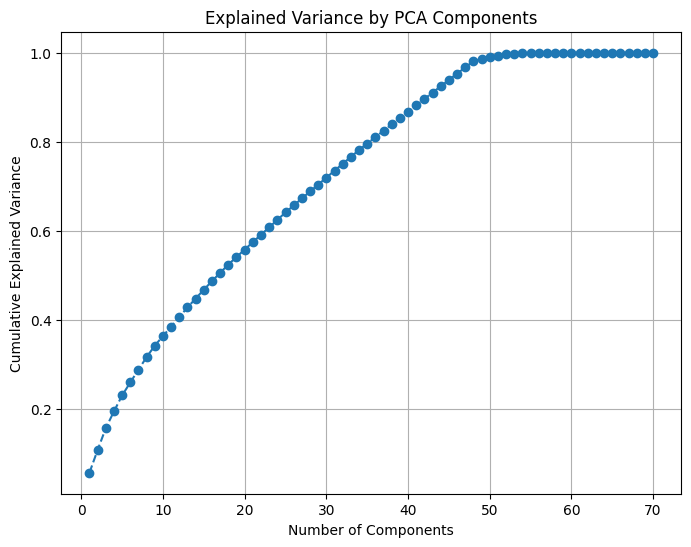

In [25]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_og)

pca = PCA()
pca.fit(scaled_data)

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [13]:
%%time
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_og)
test_scaled = scaler.transform(test_nan)

pca = PCA(n_components=45)
pca_features = pca.fit_transform(scaled_data)
test_pca = pca.transform(test_scaled)

x_extended = np.hstack((train_og, pca_features))
test_extended = np.hstack((test_nan, test_pca))

CPU times: user 8.65 s, sys: 5.14 s, total: 13.8 s
Wall time: 11.9 s


In [53]:
# original_columns = train_og.columns.tolist()
# pca_columns = [f'PCA_{i+1}' for i in range(pca_features.shape[1])]
# extended_columns = original_columns + pca_columns
# x_extended_df = pd.DataFrame(x_extended, columns=extended_columns)
# x_extended_df = x_extended_df.astype(float)
# test_extended_df = pd.DataFrame(test_extended, columns=extended_columns)
# test_extended_df = test_extended_df.astype(float)

In [14]:
folds = KFold(n_splits=10, shuffle=True, random_state=SEED)
folds_train = KFold(n_splits=5, shuffle=True, random_state=SEED)

In [17]:
%%time

def objective(trial):
    params = {
        'n_estimators': 500,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 90, 130),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.8, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 9, 13),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 60, 91),
        'max_depth': trial.suggest_int('max_depth', -1, 12),
        'lambda_l1': trial.suggest_float('lambda_l1', 3, 5),
        'lambda_l2': trial.suggest_float('lambda_l2', 5.8, 9.1),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.002, 0.006),
        'n_jobs': -1,
        'verbose': -1
    }

    model = LGBMRegressor(**params)
    scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

    for train_idx, val_idx in kf.split(pca_features):
        x_train, x_val = pca_features[train_idx], pca_features[val_idx]
        y_train, y_val = y_log[train_idx], y_log[val_idx]

        model.fit(
            x_train, y_train, 
            eval_set=[(x_val, y_val)],
            eval_metric='rmse',
            callbacks=[
                early_stopping(50),
                # log_evaluation(10)
            ])
        preds = model.predict(x_val)
        score = np.sqrt(mean_squared_error(y_val,preds))
        scores.append(score)
    return np.mean(scores)

study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=5)
best_params = study.best_params

[I 2024-12-31 09:30:34,335] A new study created in memory with name: no-name-a72f4a81-7545-41c7-9f18-e9a7b24a4549


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.08046	valid_0's l2: 1.16739
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.08047	valid_0's l2: 1.16742
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.08013	valid_0's l2: 1.16668
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.07702	valid_0's l2: 1.15997
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.07533	valid_0's l2: 1.15634


[I 2024-12-31 09:35:21,301] Trial 0 finished with value: 1.0786818719605065 and parameters: {'num_leaves': 114, 'learning_rate': 0.012511985806183077, 'feature_fraction': 0.8376303920077013, 'bagging_fraction': 0.6131425691240594, 'bagging_freq': 10, 'min_data_in_leaf': 63, 'max_depth': 9, 'lambda_l1': 4.358801047050283, 'lambda_l2': 7.363690821247121, 'min_gain_to_split': 0.0037931832979212184}. Best is trial 0 with value: 1.0786818719605065.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.08394	valid_0's l2: 1.17493
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.08402	valid_0's l2: 1.17511
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.08395	valid_0's l2: 1.17494
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.08064	valid_0's l2: 1.16778
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.07877	valid_0's l2: 1.16375


[I 2024-12-31 09:38:41,896] Trial 1 finished with value: 1.0822641694693425 and parameters: {'num_leaves': 90, 'learning_rate': 0.01810485336084989, 'feature_fraction': 0.9204897078016253, 'bagging_fraction': 0.8885332725924568, 'bagging_freq': 12, 'min_data_in_leaf': 79, 'max_depth': 5, 'lambda_l1': 3.4507083263853913, 'lambda_l2': 8.011575179745895, 'min_gain_to_split': 0.0049430663698076535}. Best is trial 0 with value: 1.0786818719605065.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.0955	valid_0's l2: 1.20012
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.09574	valid_0's l2: 1.20065
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.09574	valid_0's l2: 1.20064
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.09253	valid_0's l2: 1.19362
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.09063	valid_0's l2: 1.18948


[I 2024-12-31 09:44:07,182] Trial 2 finished with value: 1.0940280762722532 and parameters: {'num_leaves': 100, 'learning_rate': 0.00019347571557360864, 'feature_fraction': 0.9921819484473355, 'bagging_fraction': 0.6755301860304033, 'bagging_freq': 10, 'min_data_in_leaf': 84, 'max_depth': 10, 'lambda_l1': 4.088074396800832, 'lambda_l2': 7.062935181133918, 'min_gain_to_split': 0.003526603800807989}. Best is trial 0 with value: 1.0786818719605065.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.07982	valid_0's l2: 1.16602
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.07976	valid_0's l2: 1.16587
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.07964	valid_0's l2: 1.16561
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.07649	valid_0's l2: 1.15883
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.07477	valid_0's l2: 1.15512


[I 2024-12-31 09:49:59,079] Trial 3 finished with value: 1.078093253082113 and parameters: {'num_leaves': 101, 'learning_rate': 0.016626638693686285, 'feature_fraction': 0.8477973664871459, 'bagging_fraction': 0.7313165113949591, 'bagging_freq': 13, 'min_data_in_leaf': 69, 'max_depth': 9, 'lambda_l1': 4.51790731354718, 'lambda_l2': 7.17869177028363, 'min_gain_to_split': 0.002903075070384332}. Best is trial 3 with value: 1.078093253082113.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.09629	valid_0's l2: 1.20185
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.09654	valid_0's l2: 1.2024
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.09654	valid_0's l2: 1.20239
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.09333	valid_0's l2: 1.19536
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.09144	valid_0's l2: 1.19125


[I 2024-12-31 09:54:19,650] Trial 4 finished with value: 1.0948272545869933 and parameters: {'num_leaves': 107, 'learning_rate': 0.00015598795791976034, 'feature_fraction': 0.9192865373841993, 'bagging_fraction': 0.851197116693249, 'bagging_freq': 13, 'min_data_in_leaf': 66, 'max_depth': 6, 'lambda_l1': 4.790763688922551, 'lambda_l2': 6.644539073581293, 'min_gain_to_split': 0.005468929371865161}. Best is trial 3 with value: 1.078093253082113.


CPU times: user 1h 20min 3s, sys: 13 s, total: 1h 20min 16s
Wall time: 23min 45s


In [18]:
# best_params, study.best_value

({'num_leaves': 101,
  'learning_rate': 0.016626638693686285,
  'feature_fraction': 0.8477973664871459,
  'bagging_fraction': 0.7313165113949591,
  'bagging_freq': 13,
  'min_data_in_leaf': 69,
  'max_depth': 9,
  'lambda_l1': 4.51790731354718,
  'lambda_l2': 7.17869177028363,
  'min_gain_to_split': 0.002903075070384332},
 1.078093253082113)

- PCA 피처만으로 학습 시 원본 피처 학습보다 성능 하락

In [39]:
best_params, study.best_value # org + pca

({'num_leaves': 101,
  'learning_rate': 0.016626638693686285,
  'feature_fraction': 0.8477973664871459,
  'bagging_fraction': 0.7313165113949591,
  'bagging_freq': 13,
  'min_data_in_leaf': 69,
  'max_depth': 9,
  'lambda_l1': 4.51790731354718,
  'lambda_l2': 7.17869177028363,
  'min_gain_to_split': 0.002903075070384332},
 1.0469236379660614)

In [57]:
%%time
best_params = {
 'n_estimators': 1000,
 'boosting_type': 'gbdt',
 'num_leaves': 101,
 'learning_rate': 0.016626638693686285,
 'feature_fraction': 0.8477973664871459,
 'bagging_fraction': 0.7313165113949591,
 'bagging_freq': 13,
 'min_data_in_leaf': 69,
 'max_depth': 9,
 'lambda_l1': 4.51790731354718,
 'lambda_l2': 7.17869177028363,
 'min_gain_to_split': 0.002903075070384332,
 'verbose': -1,
 'n_jobs': -1
}

models_lgb_pca = []
lgbm_OOF_pca = np.zeros(len(x_extended))
lgbm_preds_pca = np.zeros(len(test_extended))

for train_idx, val_idx in folds_train.split(x_extended):
    x_train, x_val = x_extended[train_idx], x_extended[val_idx]
    y_train, y_val = y_log[train_idx], y_log[val_idx]

    model = LGBMRegressor(**best_params)
    model.fit(
        x_train, y_train, 
        eval_set=[(x_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(100),
            # log_evaluation(50)
        ])

    lgbm_OOF_pca[val_idx] += model.predict(x_val)
    lgbm_preds_pca += model.predict(test_extended) / folds_train.n_splits
    models_lgb_pca.append(model)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[303]	valid_0's rmse: 1.04825	valid_0's l2: 1.09882
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[425]	valid_0's rmse: 1.04913	valid_0's l2: 1.10068
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[325]	valid_0's rmse: 1.04917	valid_0's l2: 1.10075
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	valid_0's rmse: 1.04404	valid_0's l2: 1.09001
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[287]	valid_0's rmse: 1.04301	valid_0's l2: 1.08786
CPU times: user 20min 34s, sys: 7.35 s, total: 20min 41s
Wall time: 6min 50s


In [58]:
root_mean_squared_error(lgbm_OOF_pca50, y_log)

1.0467198643519278

원본에 PCA 피처를 더 했을 때, 원본 피처만으로 학습한 경우보다 성능이 소폭 하락

In [17]:
from sklearn.feature_selection import SelectFromModel

x_train, x_val, y_train, y_val = train_test_split(pca_features, y_log_nan, test_size=0.2, random_state=SEED)
model = LGBMRegressor(n_estimators=1000, learning_rate=0.1)
model.fit(x_train, y_train, 
    eval_set=[(x_val, y_val)], 
    eval_metric='rmse',
    callbacks=[
            early_stopping(100),
            # log_evaluation(50)
    ])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11475
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 45
[LightGBM] [Info] Start training from score 6.594502
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[649]	valid_0's rmse: 1.07995	valid_0's l2: 1.16629


LGBMRegressor(n_estimators=1000)

In [18]:
selector = SelectFromModel(model, threshold='mean', prefit=True)  # 평균 이상 중요도 기준으로 선택
selected_features = selector.transform(pca_features)  # 선택된 피처만 사용
selected_test = selector.transform(test_pca)  # 선택된 피처만 사용

print(selected_features.shape)

(1200000, 19)


In [21]:
%%time

x_extended_selected = np.hstack((train.drop(['Premium Amount'], axis=1), selected_features))
test_extended_selected = np.hstack((test, selected_test))

CPU times: user 4.3 s, sys: 3.5 s, total: 7.8 s
Wall time: 17.5 s


In [22]:
%%time

def objective(trial):
    params = {
        'n_estimators': 500,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 90, 130),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.8, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 9, 13),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 60, 91),
        'max_depth': trial.suggest_int('max_depth', -1, 12),
        'lambda_l1': trial.suggest_float('lambda_l1', 3, 5),
        'lambda_l2': trial.suggest_float('lambda_l2', 5.8, 9.1),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.002, 0.006),
        'n_jobs': -1,
        'verbose': -1
    }

    model = LGBMRegressor(**params)
    scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

    for train_idx, val_idx in kf.split(x_extended_selected):
        x_train, x_val = x_extended_selected[train_idx], x_extended_selected[val_idx]
        y_train, y_val = y_log_nan[train_idx], y_log_nan[val_idx]

        model.fit(
            x_train, y_train, 
            eval_set=[(x_val, y_val)],
            eval_metric='rmse',
            callbacks=[
                early_stopping(50),
                # log_evaluation(10)
            ])
        preds = model.predict(x_val)
        score = np.sqrt(mean_squared_error(y_val,preds))
        scores.append(score)
    return np.mean(scores)

study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=5)
best_params = study.best_params

[I 2024-12-31 10:49:14,669] A new study created in memory with name: no-name-6a76faba-ed36-425d-8b10-6b28c5e8def7


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[320]	valid_0's rmse: 1.04658	valid_0's l2: 1.09533
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[319]	valid_0's rmse: 1.04739	valid_0's l2: 1.09702
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[356]	valid_0's rmse: 1.04752	valid_0's l2: 1.09729
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[310]	valid_0's rmse: 1.04343	valid_0's l2: 1.08874
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[289]	valid_0's rmse: 1.04246	valid_0's l2: 1.08673


[I 2024-12-31 10:52:51,677] Trial 0 finished with value: 1.0454769336435932 and parameters: {'num_leaves': 114, 'learning_rate': 0.012511985806183077, 'feature_fraction': 0.8376303920077013, 'bagging_fraction': 0.6131425691240594, 'bagging_freq': 10, 'min_data_in_leaf': 63, 'max_depth': 9, 'lambda_l1': 4.358801047050283, 'lambda_l2': 7.363690821247121, 'min_gain_to_split': 0.0037931832979212184}. Best is trial 0 with value: 1.0454769336435932.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[252]	valid_0's rmse: 1.0464	valid_0's l2: 1.09496
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[280]	valid_0's rmse: 1.04724	valid_0's l2: 1.09671
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[296]	valid_0's rmse: 1.0473	valid_0's l2: 1.09683
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's rmse: 1.0434	valid_0's l2: 1.08869
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[296]	valid_0's rmse: 1.04243	valid_0's l2: 1.08665


[I 2024-12-31 10:55:20,850] Trial 1 finished with value: 1.0453541412907976 and parameters: {'num_leaves': 90, 'learning_rate': 0.01810485336084989, 'feature_fraction': 0.9204897078016253, 'bagging_fraction': 0.8885332725924568, 'bagging_freq': 12, 'min_data_in_leaf': 79, 'max_depth': 5, 'lambda_l1': 3.4507083263853913, 'lambda_l2': 8.011575179745895, 'min_gain_to_split': 0.0049430663698076535}. Best is trial 1 with value: 1.0453541412907976.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.08852	valid_0's l2: 1.18488
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.08889	valid_0's l2: 1.18568
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.08885	valid_0's l2: 1.1856
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.0856	valid_0's l2: 1.17852
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.08377	valid_0's l2: 1.17455


[I 2024-12-31 11:01:04,392] Trial 2 finished with value: 1.087125704967244 and parameters: {'num_leaves': 100, 'learning_rate': 0.00019347571557360864, 'feature_fraction': 0.9921819484473355, 'bagging_fraction': 0.6755301860304033, 'bagging_freq': 10, 'min_data_in_leaf': 84, 'max_depth': 10, 'lambda_l1': 4.088074396800832, 'lambda_l2': 7.062935181133918, 'min_gain_to_split': 0.003526603800807989}. Best is trial 1 with value: 1.0453541412907976.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[204]	valid_0's rmse: 1.04663	valid_0's l2: 1.09542
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[247]	valid_0's rmse: 1.04735	valid_0's l2: 1.09695
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[234]	valid_0's rmse: 1.0475	valid_0's l2: 1.09725
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[240]	valid_0's rmse: 1.0435	valid_0's l2: 1.08889
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[219]	valid_0's rmse: 1.0425	valid_0's l2: 1.08681


[I 2024-12-31 11:05:08,257] Trial 3 finished with value: 1.0454928569610815 and parameters: {'num_leaves': 101, 'learning_rate': 0.016626638693686285, 'feature_fraction': 0.8477973664871459, 'bagging_fraction': 0.7313165113949591, 'bagging_freq': 13, 'min_data_in_leaf': 69, 'max_depth': 9, 'lambda_l1': 4.51790731354718, 'lambda_l2': 7.17869177028363, 'min_gain_to_split': 0.002903075070384332}. Best is trial 1 with value: 1.0453541412907976.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.09015	valid_0's l2: 1.18842
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.0905	valid_0's l2: 1.18918
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.09046	valid_0's l2: 1.18911
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.08722	valid_0's l2: 1.18204
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.08538	valid_0's l2: 1.17806


[I 2024-12-31 11:11:32,781] Trial 4 finished with value: 1.0887409950129308 and parameters: {'num_leaves': 107, 'learning_rate': 0.00015598795791976034, 'feature_fraction': 0.9192865373841993, 'bagging_fraction': 0.851197116693249, 'bagging_freq': 13, 'min_data_in_leaf': 66, 'max_depth': 6, 'lambda_l1': 4.790763688922551, 'lambda_l2': 6.644539073581293, 'min_gain_to_split': 0.005468929371865161}. Best is trial 1 with value: 1.0453541412907976.


CPU times: user 1h 10min 13s, sys: 24.3 s, total: 1h 10min 37s
Wall time: 22min 18s


In [23]:
best_params, study.best_value

({'num_leaves': 90,
  'learning_rate': 0.01810485336084989,
  'feature_fraction': 0.9204897078016253,
  'bagging_fraction': 0.8885332725924568,
  'bagging_freq': 12,
  'min_data_in_leaf': 79,
  'max_depth': 5,
  'lambda_l1': 3.4507083263853913,
  'lambda_l2': 8.011575179745895,
  'min_gain_to_split': 0.0049430663698076535},
 1.0453541412907976)

In [24]:
%%time
best_params = {
 'n_estimators': 1000,
 'boosting_type': 'gbdt',
 'num_leaves': 90,
 'learning_rate': 0.01810485336084989,
 'feature_fraction': 0.9204897078016253,
 'bagging_fraction': 0.8885332725924568,
 'bagging_freq': 12,
 'min_data_in_leaf': 79,
 'max_depth': 5,
 'lambda_l1': 3.4507083263853913,
 'lambda_l2': 8.011575179745895,
 'min_gain_to_split': 0.0049430663698076535,
 'verbose': -1,
 'n_jobs': -1
}

models_lgb_pca = []
lgbm_OOF_pca = np.zeros(len(x_extended_selected))
lgbm_preds_pca = np.zeros(len(test_extended_selected))

for train_idx, val_idx in folds_train.split(x_extended_selected):
    x_train, x_val = x_extended_selected[train_idx], x_extended_selected[val_idx]
    y_train, y_val = y_log[train_idx], y_log[val_idx]

    model = LGBMRegressor(**best_params)
    model.fit(
        x_train, y_train, 
        eval_set=[(x_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(100),
            # log_evaluation(50)
        ])

    lgbm_OOF_pca[val_idx] += model.predict(x_val)
    lgbm_preds_pca += model.predict(test_extended_selected) / folds_train.n_splits
    models_lgb_pca.append(model)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[252]	valid_0's rmse: 1.0464	valid_0's l2: 1.09496
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[280]	valid_0's rmse: 1.04724	valid_0's l2: 1.09671
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[296]	valid_0's rmse: 1.0473	valid_0's l2: 1.09683
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[231]	valid_0's rmse: 1.0434	valid_0's l2: 1.08869
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[296]	valid_0's rmse: 1.04243	valid_0's l2: 1.08665
CPU times: user 14min 19s, sys: 6.84 s, total: 14min 26s
Wall time: 5min


In [26]:
root_mean_squared_error(lgbm_OOF_pca, y_log)

1.0453561329117549

# Model

In [27]:
train['pred'] = meta_oof
test['pred'] = meta_pred

train['pred_mean'] = OOF_mean 
train['pred_min'] = OOF_min 
train['pred_max'] = OOF_max 

test['pred_mean'] = pred_mean 
test['pred_min'] = pred_min 
test['pred_max'] = pred_max 

In [31]:
x = train.drop('Premium Amount', axis=1)
y = train['Premium Amount']

y_log = np.log1p(y)

folds = KFold(n_splits=5, shuffle=True, random_state=42)

## LGBM

In [42]:
%%time

def objective(trial):
    params = {
        'n_estimators': 500,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.03, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.85, 0.99),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 15, 21),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 60, 87),
        'max_depth': trial.suggest_int('max_depth', -1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 2.5, 4.5),
        'lambda_l2': trial.suggest_float('lambda_l2', 6.5, 9.2),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.007, 0.01),
        'n_jobs': -1,
        'verbose': -1
    }

    model = LGBMRegressor(**params)
    scores = []

    for train_idx, val_idx in folds.split(x):
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y_log.iloc[train_idx], y_log.iloc[val_idx]

        model.fit(
            x_train, y_train, 
            eval_set=[(x_val, y_val)],
            eval_metric='rmse',
            callbacks=[
                early_stopping(50),
                # log_evaluation(10)
            ])
        preds = model.predict(x_val)
        score = np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(preds)))
        scores.append(score)
    return np.mean(scores)

study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=5)

best_params = study.best_params

[I 2024-12-31 13:15:28,806] A new study created in memory with name: no-name-738312f4-a0da-4dfb-8f03-c649dde5631b


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's rmse: 1.04604	valid_0's l2: 1.09421
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[235]	valid_0's rmse: 1.04504	valid_0's l2: 1.09211
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[240]	valid_0's rmse: 1.04619	valid_0's l2: 1.09451
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	valid_0's rmse: 1.0438	valid_0's l2: 1.08952
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[243]	valid_0's rmse: 1.04538	valid_0's l2: 1.09282


[I 2024-12-31 13:18:02,004] Trial 0 finished with value: 1.0452911362325086 and parameters: {'num_leaves': 38, 'learning_rate': 0.02155557652018214, 'feature_fraction': 0.8763412744053908, 'bagging_fraction': 0.808761712749373, 'bagging_freq': 16, 'min_data_in_leaf': 62, 'max_depth': 5, 'lambda_l1': 3.8588010470502834, 'lambda_l2': 7.77938339920219, 'min_gain_to_split': 0.008344887473440914}. Best is trial 0 with value: 1.0452911362325086.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[237]	valid_0's rmse: 1.04599	valid_0's l2: 1.0941
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[276]	valid_0's rmse: 1.04508	valid_0's l2: 1.09218
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[257]	valid_0's rmse: 1.0462	valid_0's l2: 1.09453
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[279]	valid_0's rmse: 1.04374	valid_0's l2: 1.08939
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[283]	valid_0's rmse: 1.04541	valid_0's l2: 1.09289


[I 2024-12-31 13:20:17,255] Trial 1 finished with value: 1.0452834381133358 and parameters: {'num_leaves': 20, 'learning_rate': 0.022860233546174735, 'feature_fraction': 0.9343427954611377, 'bagging_fraction': 0.9923555150616379, 'bagging_freq': 19, 'min_data_in_leaf': 76, 'max_depth': 3, 'lambda_l1': 2.9507083263853913, 'lambda_l2': 8.309470601610277, 'min_gain_to_split': 0.009207299777355741}. Best is trial 1 with value: 1.0452834381133358.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[464]	valid_0's rmse: 1.046	valid_0's l2: 1.09411
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[411]	valid_0's rmse: 1.04507	valid_0's l2: 1.09217
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[483]	valid_0's rmse: 1.04624	valid_0's l2: 1.09462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[419]	valid_0's rmse: 1.04381	valid_0's l2: 1.08954
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid_0's rmse: 1.04538	valid_0's l2: 1.09282


[I 2024-12-31 13:23:54,077] Trial 2 finished with value: 1.0452994960244837 and parameters: {'num_leaves': 27, 'learning_rate': 0.011106703859405143, 'feature_fraction': 0.9845273639131349, 'bagging_fraction': 0.8503534573536022, 'bagging_freq': 16, 'min_data_in_leaf': 81, 'max_depth': 6, 'lambda_l1': 3.588074396800832, 'lambda_l2': 7.533310602745933, 'min_gain_to_split': 0.008144952850605992}. Best is trial 1 with value: 1.0452834381133358.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[181]	valid_0's rmse: 1.04599	valid_0's l2: 1.0941
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[210]	valid_0's rmse: 1.04504	valid_0's l2: 1.0921
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[260]	valid_0's rmse: 1.04623	valid_0's l2: 1.09459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[238]	valid_0's rmse: 1.04379	valid_0's l2: 1.0895
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[237]	valid_0's rmse: 1.04539	valid_0's l2: 1.09284


[I 2024-12-31 13:26:12,877] Trial 3 finished with value: 1.0452873330135102 and parameters: {'num_leaves': 28, 'learning_rate': 0.022552654674491787, 'feature_fraction': 0.883458156541002, 'bagging_fraction': 0.8875443409299728, 'bagging_freq': 21, 'min_data_in_leaf': 68, 'max_depth': 6, 'lambda_l1': 4.01790731354718, 'lambda_l2': 7.62802053932297, 'min_gain_to_split': 0.007677306302788249}. Best is trial 1 with value: 1.0452834381133358.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid_0's rmse: 1.04601	valid_0's l2: 1.09413
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid_0's rmse: 1.0451	valid_0's l2: 1.09222
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[440]	valid_0's rmse: 1.0462	valid_0's l2: 1.09453
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[483]	valid_0's rmse: 1.04375	valid_0's l2: 1.08942
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1.04544	valid_0's l2: 1.09295


[I 2024-12-31 13:29:28,853] Trial 4 finished with value: 1.0452992397762013 and parameters: {'num_leaves': 33, 'learning_rate': 0.010732707285467727, 'feature_fraction': 0.9335005761689396, 'bagging_fraction': 0.967464744462166, 'bagging_freq': 21, 'min_data_in_leaf': 65, 'max_depth': 3, 'lambda_l1': 4.290763688922551, 'lambda_l2': 7.190986514748331, 'min_gain_to_split': 0.00960169702889887}. Best is trial 1 with value: 1.0452834381133358.


CPU times: user 44min 34s, sys: 13.4 s, total: 44min 48s
Wall time: 14min


In [43]:
best_params, study.best_value

({'num_leaves': 20,
  'learning_rate': 0.022860233546174735,
  'feature_fraction': 0.9343427954611377,
  'bagging_fraction': 0.9923555150616379,
  'bagging_freq': 19,
  'min_data_in_leaf': 76,
  'max_depth': 3,
  'lambda_l1': 2.9507083263853913,
  'lambda_l2': 8.309470601610277,
  'min_gain_to_split': 0.009207299777355741},
 1.0452834381133358)

In [ ]:
# ({'num_leaves': 90,
#   'learning_rate': 0.01810485336084989,
#   'feature_fraction': 0.9204897078016253,
#   'bagging_fraction': 0.8885332725924568,
#   'bagging_freq': 12,
#   'min_data_in_leaf': 79,
#   'max_depth': 5,
#   'lambda_l1': 3.4507083263853913,
#   'lambda_l2': 8.011575179745895,
#   'min_gain_to_split': 0.0049430663698076535},
#  1.045273450566226)

In [44]:
%%time
best_params = {
'n_estimators': 1000,
'boosting_type': 'gbdt',
'num_leaves': 20,
'learning_rate': 0.022860233546174735,
'feature_fraction': 0.9343427954611377,
'bagging_fraction': 0.9923555150616379,
'bagging_freq': 19,
'min_data_in_leaf': 76,
'max_depth': 3,
'lambda_l1': 2.9507083263853913,
'lambda_l2': 8.309470601610277,
'min_gain_to_split': 0.009207299777355741,
'verbose': -1,
'n_jobs': -1
}

models_lgb = []
lgbm_OOF = np.zeros(len(x))
lgbm_preds = np.zeros(len(test))

for train_idx, val_idx in folds.split(x):
    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y_log.iloc[train_idx], y_log.iloc[val_idx]

    model = LGBMRegressor(**best_params)
    model.fit(
        x_train, y_train, 
        eval_set=[(x_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(100),
            # log_evaluation(50)
        ])

    lgbm_OOF[val_idx] += model.predict(x_val)
    lgbm_preds += model.predict(test) / folds.n_splits
    models_lgb.append(model)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	valid_0's rmse: 1.04599	valid_0's l2: 1.0941
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[276]	valid_0's rmse: 1.04508	valid_0's l2: 1.09218
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[257]	valid_0's rmse: 1.0462	valid_0's l2: 1.09453
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[279]	valid_0's rmse: 1.04374	valid_0's l2: 1.08939
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[422]	valid_0's rmse: 1.04541	valid_0's l2: 1.09288
CPU times: user 9min 49s, sys: 3.83 s, total: 9min 53s
Wall time: 3min 13s


In [45]:
print("Validation RMSE:", np.sqrt(mean_squared_error(y_log, lgbm_OOF)))

Validation RMSE: 1.045283213407708


> 참고(OOF)
1. 기저모델(LGBM) - 1.046063550028496
2. 현재 베스트 - 1.0452650462992732

---

# Submission

In [26]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545
2,1200002,1102.545
3,1200003,1102.545
4,1200004,1102.545


In [27]:
meta_preds = np.expm1(meta_lgbm_preds)

In [28]:
submission['Premium Amount'] = meta_preds
submission.head()

,id,Premium Amount
0,1200000,783.842769
1,1200001,787.437395
2,1200002,803.820039
3,1200003,806.575528
4,1200004,752.637634


In [30]:
submission.to_csv('./data/04_05.csv', index=False)
!kaggle competitions submit -c playground-series-s4e12 -f "./data/04_05.csv" -m "04_05_stacking_04"

100%|██████████████████████████████████████| 19.8M/19.8M [00:00<00:00, 39.2MB/s]
Successfully submitted to Regression with an Insurance Dataset

In [46]:
from kaggle.api.kaggle_api_extended import KaggleApi
from datetime import datetime

# Kaggle API 인증
api = KaggleApi()
api.authenticate()

# 대회 이름 설정
competition = 'playground-series-s4e12'

# 제출 기록 불러오기
submissions = api.competition_submissions(competition)

# 오늘 날짜 (UTC 기준)
today = datetime.utcnow().date()

# 제출 날짜 비교 및 오늘 제출 횟수 계산
today_submissions = [
    sub for sub in submissions 
    if sub.date.date() == today  # 여기서 바로 date() 호출
]

# 결과 출력
used_submissions = len(today_submissions)
remaining_submissions = 5 - used_submissions

print(f"오늘 제출 횟수: {used_submissions}")
print(f"남은 제출 횟수: {remaining_submissions}")

오늘 제출 횟수: 1
남은 제출 횟수: 4


: 